# Burgers' Equation Example

In this notebook we show how to use the PDE solver to solve Burgers' equation in 1D.

Burgers' equation in 1D is
$$
\frac{\partial u}{\partial t} = -u \frac{\partial u}{\partial x} 
+ \nu \frac{\partial^2 u}{\partial x^2},
$$
where $u(x, t)$ is some field with viscosity $\nu$.

In this example, we use Dirichlet boundary conditions 
$$ 
u(t, x=0) = u(t, x=L) = 0,
$$
where $x=0$ and $x=L$ are the left and right boundaries of a domain with length
$L$.

We will solve this in a time-stepping approach with an implicit Euler method.

Let's import the required packages:

In [2]:
import time
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt

from jax_fno import solver

First, let's set up the system of equations:

In [3]:
def central_diff_dirichlet(
    u: jnp.ndarray, 
    bc_left: float, 
    bc_right: float, 
    dx: float
) -> jnp.ndarray:
    """
    Take the first derivative of u in a finite difference approach.

    Assumes the boundary points are ghost points with Dirichlet conditions.

    Args:
        u: The array to be differenced
        bc_left: The value at the left boundary (i.e. first ghost point)
        bc_right: The value at the right boundary (i.e. last ghost point)
        dx: The grid spacing
    """
    backdiff = jnp.diff(u, prepend=bc_left)  # backward difference
    frontdiff = jnp.diff(u, append=bc_right)  # forward difference
    return (backdiff + frontdiff) / (2 * dx)  # central difference

def laplacian_dirichlet_1d(
    u: jnp.ndarray, 
    bc_left: float, 
    bc_right: float, 
    dx: float
) -> jnp.ndarray:
    """
    Take the Laplacian of u in a finite difference approach.

    Assumes the boundary points are ghost points with Dirichlet conditions.

    Args:
        u: The array to be differenced
        bc_left: The value at the left boundary (i.e. first ghost point)
        bc_right: The value at the right boundary (i.e. last ghost point)
        dx: The grid spacing
    """
    return jnp.diff(jnp.diff(u, prepend=bc_left, append=bc_right)) / dx**2

def burgers_rhs(
    t: float, 
    u: jnp.ndarray,
    nu: float,
    bc_left: float, 
    bc_right: float, 
    dx: float
) -> jnp.ndarray:
    """
    Compute right-hand side of du/dt = -u du/dx + nu d2u/dx2.

    Args:
        t: Current time
        u: Current solution (shape: (nx,))
        nu: Viscosity
        bc_left: The value at the left boundary (i.e. first ghost point)
        bc_right: The value at the right boundary (i.e. last ghost point)
        dx: The grid spacing

    Returns:
        Time derivative du/dt (shape: (nx,))
    """
    du_dx = central_diff_dirichlet(u, bc_left, bc_right, dx)
    d2u_dx2 = laplacian_dirichlet_1d(u, bc_left, bc_right, dx)
    return -u * du_dx + nu * d2u_dx2

Set parameters:

In [19]:
nu = 1e-2
bc_values = (0.0, 0.0)
L = 2.0  # Domain length
nx = 128  # grid points
dx = L / (nx + 1)  # grid spacing
x = jnp.arange(dx, L, dx)  # grid

fun = lambda t, u : burgers_rhs(t, u, nu, bc_values[0], bc_values[1], dx)

Initial condition:

In [20]:
# Create Gaussian initial condition
center=1.0
width=0.2
amplitude=0.5
y0 = amplitude * jnp.exp(-((x - center) / width) ** 2)

Solve the equation:

In [21]:
# Times at which to evaluate
t_span = (0.0, 2.0)  # (start_time, end_time)
t_eval = jnp.linspace(t_span[0], t_span[1], 4, endpoint=True)

# Solve the equation
t, u = solver.solve_ivp(
    fun,
    t_span,
    y0,
    stepper=solver.BackwardEuler(),
    dt=1e-1,
    t_eval=t_eval  # Note: each save triggers a recompilation
)

Plot the solution:

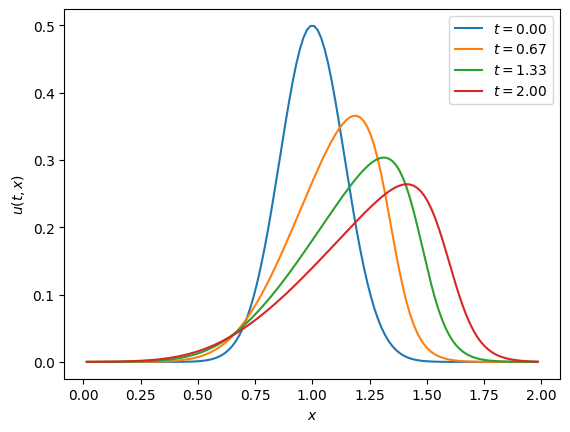

In [22]:
fig, ax = plt.subplots()
for i in range(len(t)):
    ax.plot(x, u[i, :], label=f'$t={t[i]:.2f}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t, x)$')
ax.legend();